In [1]:
import os 
import re
import numpy as np
import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt 
%matplotlib inline 

In [2]:
TRAIN_PATH = Path.cwd()/'Dataset/train'
TEST_PATH = Path.cwd()/'Dataset/test'
POS_WORDS_PATH = Path.cwd()/'Dataset/positive-words.txt'
NEG_WORDS_PATH = Path.cwd()/'Dataset/negative-words.txt'

def get_words_list():
    """ Returns lists of positive and negative lexicon. """
    # Get positive lexicon 
    with open(POS_WORDS_PATH, "r") as file:
        pos_words = [word.strip().lower() for word in file.readlines()]
    # Get negative lexicon
    with open(NEG_WORDS_PATH, "r") as file:
        neg_words = [word.strip().lower() for word in file.readlines()]
    return pos_words, neg_words


POS_WORDS, NEG_WORDS = get_words_list()

In [3]:
def log_word_count(text):
    """ Returns the log of the word count of a movie review."""
    return np.log(len(text))


def pos_neg_word_count(text):
    """ Return the number of positive words in a movie review.
    Positive words are already provided in the positive-words.txt"""
    pos_count = 0
    neg_count = 0

    for word in text:
        if word in POS_WORDS:
            pos_count += 1 
        if word in NEG_WORDS:
            neg_count += 1
    return pos_count, neg_count


def special_character(text):
    """ Checks two conditions:
    
    1. Returns 1 if "no" in review, 0 otherwise.
    2. Returns 1 if "!" in review, 0 otherwise. 
    
    """
    no_flag = 0
    exclamation_flag = 0
    no_list = ['no', 'no.', 'no!', 'no?', 'no*']
    for word in text:
        if word in no_list:
            no_flag = 1
        if '!' in word:
            exclamation_flag = 1
        if no_flag and exclamation_flag:
            return no_flag, exclamation_flag
    return no_flag, exclamation_flag 

    
# Lambda function to get rating of a review from the filename
get_rating = lambda x : int(Path(x).stem.split('_')[1])


In [4]:
def preprocessing(path=TRAIN_PATH):
    sentiment_classes = ['pos', 'neg']
    X_neg, X_pos = [], []
    for cls in sentiment_classes:
        for review in os.listdir(path/cls):
            file_path = path/cls/review
            features = []
            with open(file_path, 'r', encoding='utf-8') as file:
                # text = file.readline(encoding='utf-8')
                text = file.readline()
            # print(text)
            text = [word.strip().lower() for word in text.split(' ')]

            # X1 holds count of positive words in a review 
            # X2 holds count of negative words in a review 
            x1, x2 = pos_neg_word_count(text)
            

            # X3 stores the movie rating given by the reviewer
            x3 = get_rating(review)
            
            # X4 stores the log of the word count of a review 
            x4 = log_word_count(text)
            
            # X5 is 1 if 'no' in the review else 0
            # X6 is 1 if '!' in the review else 0
            x5, x6 = special_character(text)
            # print(x5, x6)
            features = [x1,x2,x3,x4,x5,x6]
            if cls == 'neg':
                X_neg.append(features)
            elif cls == 'pos':
                X_pos.append(features)
            # break
    return X_neg, X_pos
              

In [5]:
X_neg, X_pos = preprocessing()

In [6]:
X_neg, X_pos = np.array(X_neg), np.array(X_pos)

In [120]:
# Depending on your computer's hardware, the preprocessing function may take a few minutes to run
# Once it does, it may prove wise to store the results to make loading much quicker
np.savetxt('X_neg.txt', X_neg, fmt='%f')
np.savetxt('X_pos.txt', X_pos, fmt='%f')

In [121]:
X_neg = np.loadtxt('X_neg.txt')
X_pos = np.loadtxt('X_pos.txt')

In [122]:
X_neg.shape

(12500, 6)

In [123]:
X = np.concatenate((X_neg, X_pos), axis=0)

In [124]:
# Run this cell only once

# Attach labels 
X_original = X.copy()
y = np.concatenate((np.zeros(12500), np.ones(12500))).reshape(-1,1)
X = np.concatenate((X, y), axis=1)
print(X.shape)

# Now, we can shuffle our feature matrix without losing track of the pos and neg labels
np.random.shuffle(X)

(25000, 7)


In [125]:
X.shape

(25000, 7)

In [126]:
# Now, we can safely remove the labels from our feature vector
y, X = X[:, -1], X[:, :-1]
print(y)
print(X.shape)
print(y.shape)

[1. 0. 1. ... 0. 0. 0.]
(25000, 6)
(25000,)


# Logistic Regression

Now, we can work on developing our machine learning model

In [299]:
class LogisticRegression(object):

    def __init__(self, alpha=0.1, epochs=100, mode='sgd'):
        self.alpha = alpha
        self.epochs = epochs
        self.mode = mode 
        self.theta = None 
        self.cost = []
    
    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def loss(self, y_hat, y):
        """ Cross Entropy Loss is used as the Loss Function"""
        return (- y * (np.log(y_hat)) - (1 - y) * np.log(1 - y_hat)).mean()

    def fit(self, X, Y, concat=True):

        if concat:
            X = np.c_[np.ones_like(X[:, 0]), X]
            Y = Y.reshape(-1, 1)
        
        self.theta = np.random.rand(X.shape[1]).reshape(-1,1)

        if self.mode == "bgd":
            for _ in range(self.epochs):
                z = X @ self.theta 
                y_hat = self.sigmoid(z)
                dY = y_hat - Y 
                gradient = np.dot(X.T, dY) / Y.size
                self.theta -= self.alpha * gradient
                cost = self.loss(y_hat, Y)
                self.cost.append(cost)
        
        elif self.mode == "sgd":
            for _ in range(self.epochs):
                for i in range(Y.size):
                    x = X[i].reshape(1, -1)
                    y = Y[i].reshape(1, -1)
                    z = x @ self.theta
                    y_hat = self.sigmoid(z)
                    dy = y_hat - y 
                    gradient = x.T @ dy 
                    self.theta -= self.alpha * gradient
                Z = X @ self.theta 
                y_hat = self.sigmoid(Z)
                cost = self.loss(y_hat, Y)
                self.cost.append(cost)
        else:
            print("Mode not recognised.")

    
    def predict(self, X, concat=True):
        if concat:
            X = np.c_[np.ones_like(X[:, 0]), X]
            
        y_hat = self.sigmoid(X @ self.theta)
        return y_hat.round()

    def evaluate(self, X, Y):
        """ Returns a confusion matrix"""
        Y = Y.reshape(-1, 1)
        Y_pred = self.predict(X)
        TP = ((Y_pred == 1) & (Y == 1)).sum()
        TN = ((Y_pred == 0) & (Y == 0)).sum()
        FP = ((Y_pred == 1) & (Y == 0)).sum()
        FN = ((Y_pred == 0) & (Y == 1)).sum()

        precision = (TP) / (TP + FP)
        recall = (TP) / (TP + FN)
        accuracy = (TP + TN) / (TP + TN + FN + FP)
        F1_score = 2 * ((precision * recall) / (precision + recall))

        print ('Precision: %.4f' %precision)
        print ('Recall: %.4f' %recall)
        print ('Accuracy: %.4f' %accuracy)
        print ('F1 score: %.4f' %F1_score)
        
        cm = np.array([TP,FP,FN,TN]).reshape(2,2)
        
        g = sns.heatmap(cm, annot=True, fmt = ".0f",
                    xticklabels=['pos','neg'], yticklabels=['pos','neg'])
        plt.xlabel('Gold Labels', fontsize=14)
        plt.ylabel('System Output', fontsize=14)
        g.figure.set_size_inches(6, 4)


In [307]:
EPOCHS = 1000
ALPHA = 0.01
lr = LogisticRegression(alpha = ALPHA, epochs=EPOCHS, mode='sgd')
lr.fit(X, y)

<AxesSubplot:>

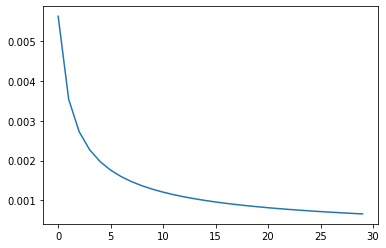

In [308]:
# Check if model is performing as expected
sns.lineplot(x=np.arange(EPOCHS), y=lr.cost)

# Evaluating our model

In [18]:
X_test_neg, X_test_pos = preprocessing(path=TEST_PATH)

In [19]:
X_test_neg, X_test_pos = np.array(X_test_neg), np.array(X_test_pos)

# We save these test results as well, just for our use and reference later
np.savetxt('X_test_neg', X_test_neg, fmt='%f')
np.savetxt('X_test_pos', X_test_pos, fmt='%f')

In [106]:
X_test_neg = np.loadtxt('X_test_neg')
X_test_pos = np.loadtxt('X_test_pos')

In [107]:
X_test = np.concatenate((X_test_neg, X_test_pos), axis=0)

In [108]:
# Run this cell only once

# Attach labels 
X_test_original = X_test.copy()
y_test = np.concatenate((np.zeros(12500), np.ones(12500))).reshape(-1,1)
X_test = np.concatenate((X_test, y_test), axis=1)
print(X_test.shape)

# Now, we can shuffle our feature matrix without losing track of the pos and neg labels
np.random.shuffle(X)

(25000, 7)


In [109]:
# Now, we can safely remove the labels from our feature vector
y_test, X_test = X_test[:, -1], X_test[:, :-1]
print(y_test)
print(X_test.shape)
print(y_test.shape)

[0. 0. 0. ... 1. 1. 1.]
(25000, 6)
(25000,)


Precision: 0.9999
Recall: 1.0000
Accuracy: 1.0000
F1 score: 1.0000


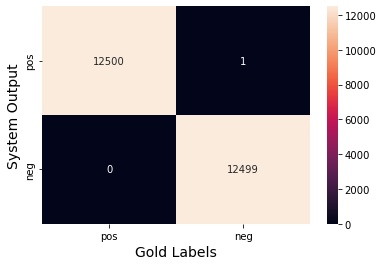

In [309]:
lr.evaluate(X_test, y_test)

# Built-in Model

In [310]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()

In [311]:
logreg.fit(X, y)

LogisticRegression()

In [312]:
print(logreg.predict(X_test))
print(y_test)

[0. 0. 0. ... 1. 1. 1.]
[0. 0. 0. ... 1. 1. 1.]


In [313]:
(logreg.predict(X_test) == y_test).sum()
# Note that the model results in 100% accuracy 

25000